<a href="https://colab.research.google.com/github/anna01122002/CourseWork/blob/main/FinalWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score,precision_score, recall_score,f1_score
import optuna
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist



4422102/4422102 [==============================] - 0s 0us/step
Форма train_images: (60000, 28, 28)
Количество изображений в обучающей выборке: 60000
Размер изображений: 28 x 28
Количество классов: 10


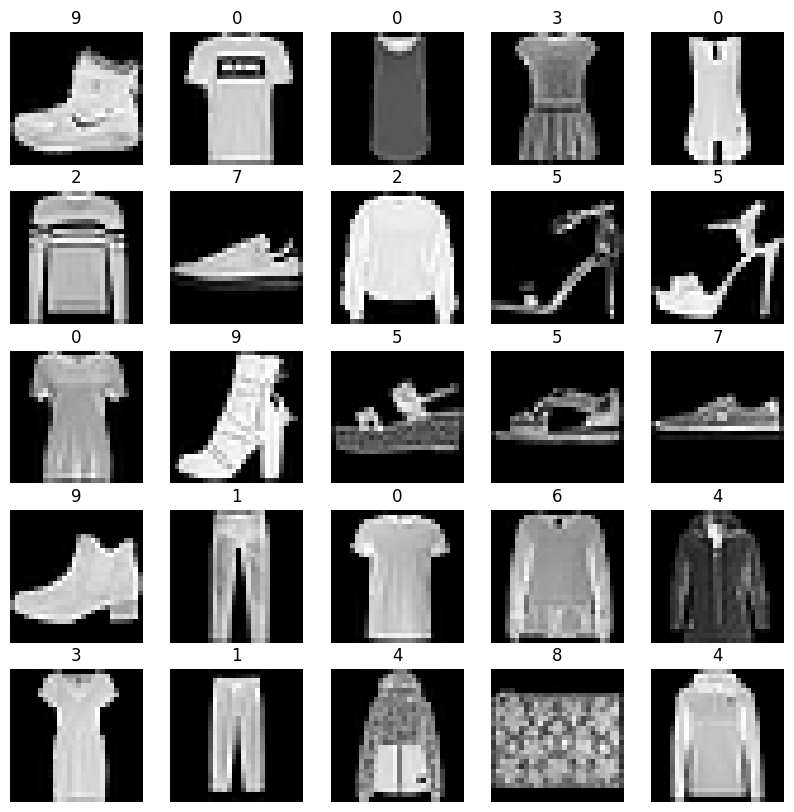

Размер обучающей выборки: 54000
Размер валидационной выборки: 6000
Размер тестовой выборки: 10000


In [ ]:
# Загрузка данных
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Вывод информации о форме и размере данных
print("Форма train_images:", train_images.shape)
print("Количество изображений в обучающей выборке:", train_images.shape[0])
print("Размер изображений:", train_images.shape[1], "x", train_images.shape[2])
print("Количество классов:", len(np.unique(train_labels)))

# Вывод нескольких изображений для иллюстрации
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(train_labels[i])
    plt.axis('off')
plt.show()

# Преобразование значений пикселей в диапазон [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Разделение на обучающую, валидационную и тестовую выборки
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42, stratify=train_labels)

print("Размер обучающей выборки:", train_images.shape[0])
print("Размер валидационной выборки:", val_images.shape[0])
print("Размер тестовой выборки:", test_images.shape[0])

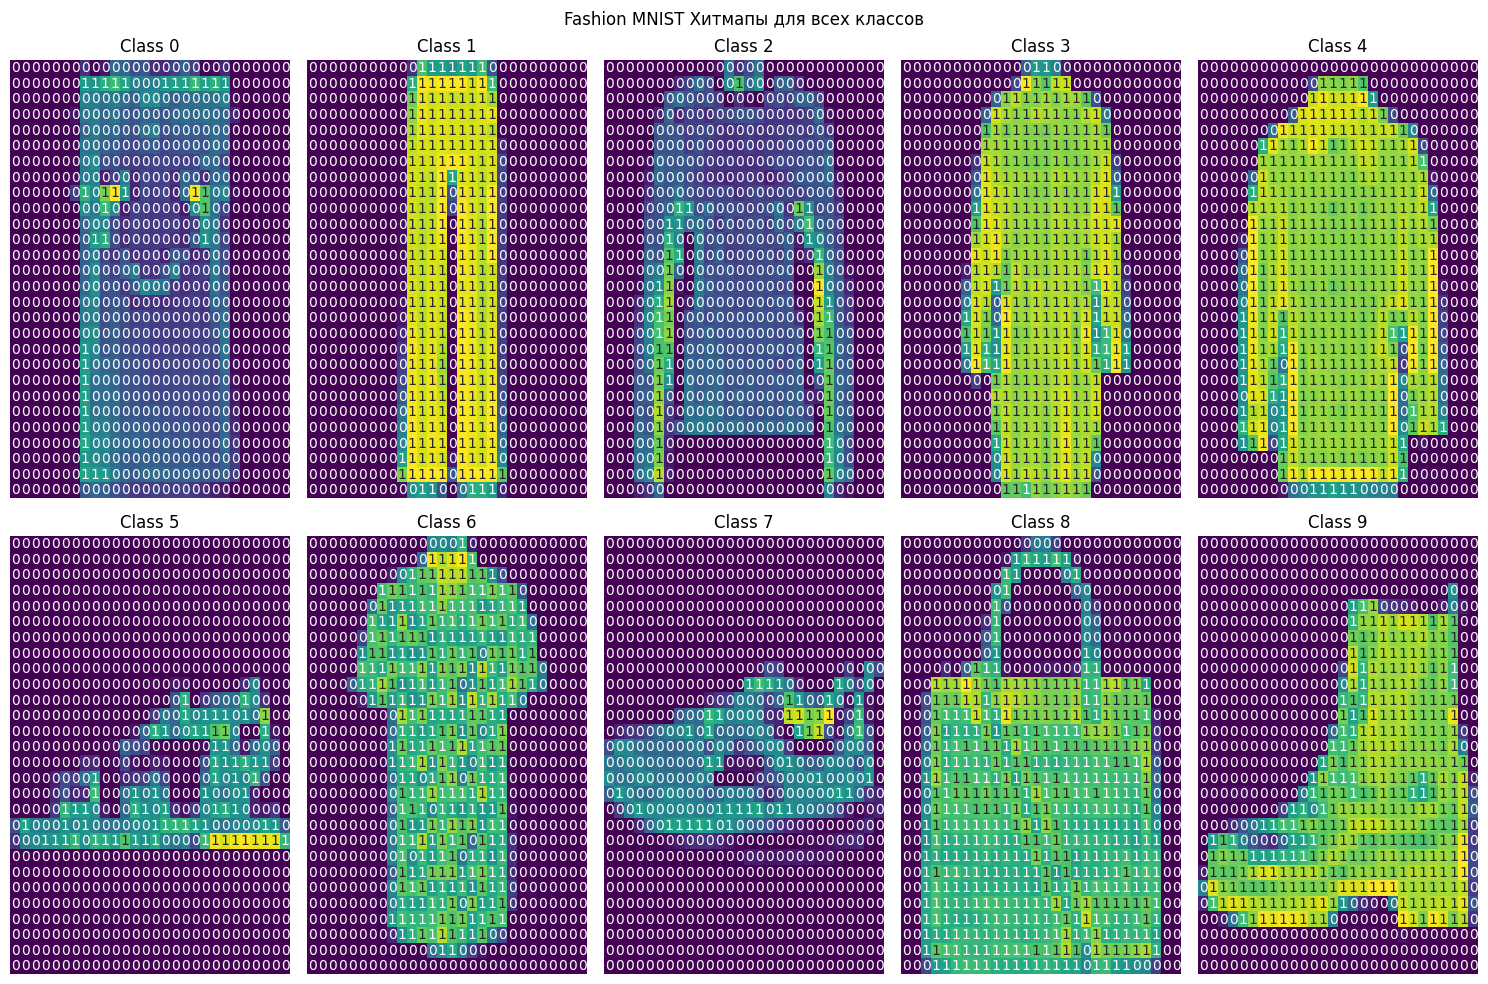

In [ ]:
import seaborn as sns

# Создание словаря для хранения по одному изображению из каждого класса
class_images = {}
num_classes = 10

for class_idx in range(num_classes):
    class_images[class_idx] = train_images[train_labels == class_idx][0]

# Создание хитмапов для каждого класса
plt.figure(figsize=(15, 10))
for class_idx, image in class_images.items():
    plt.subplot(2, 5, class_idx + 1)
    sns.heatmap(image, cmap='viridis', annot=True, fmt=".0f", cbar=False)
    plt.title(f"Class {class_idx}")
    plt.axis('off')

plt.suptitle("Fashion MNIST Хитмапы для всех классов")
plt.tight_layout()
plt.show()






In [ ]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall

In [ ]:
# Подготовка данных
train_dataset = TensorDataset(torch.Tensor(train_images), torch.LongTensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(val_images), torch.LongTensor(val_labels))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Определение архитектуры модели
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Создание экземпляра модели
model = NeuralNetwork()

# Определение функции ошибки и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, precision, recall, f1

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, train_loader, criterion, optimizer)
    val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Validation Precision: {val_precision:.4f}, "
          f"Validation Recall: {val_recall:.4f}, "
          f"Validation F1-score: {val_f1:.4f}")

# Оценка качества на тестовых данных
test_dataset = TensorDataset(torch.Tensor(test_images), torch.LongTensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}, "
      f"Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}, "
      f"Test F1-score: {test_f1:.4f}")



Epoch [1/10], Validation Accuracy: 0.8618, Validation Precision: 0.8655, Validation Recall: 0.8618, Validation F1-score: 0.8610
Epoch [2/10], Validation Accuracy: 0.8663, Validation Precision: 0.8764, Validation Recall: 0.8663, Validation F1-score: 0.8679
Epoch [3/10], Validation Accuracy: 0.8838, Validation Precision: 0.8860, Validation Recall: 0.8838, Validation F1-score: 0.8817
Epoch [4/10], Validation Accuracy: 0.8938, Validation Precision: 0.8945, Validation Recall: 0.8938, Validation F1-score: 0.8939
Epoch [5/10], Validation Accuracy: 0.8852, Validation Precision: 0.8889, Validation Recall: 0.8852, Validation F1-score: 0.8838
Epoch [6/10], Validation Accuracy: 0.8903, Validation Precision: 0.8928, Validation Recall: 0.8903, Validation F1-score: 0.8910
Epoch [7/10], Validation Accuracy: 0.8957, Validation Precision: 0.8964, Validation Recall: 0.8957, Validation F1-score: 0.8957
Epoch [8/10], Validation Accuracy: 0.8943, Validation Precision: 0.8943, Validation Recall: 0.8943, Vali

In [ ]:
# Простая полносвязная сеть
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Полносвязная нейронная сеть с дополнительными скрытыми слоями
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_stack(x)
        logits = self.fc(x)
        return logits


# Простая рекуррентная нейронная сеть (RNN)
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=28, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        out, _ = self.rnn(x)
        logits = self.fc(out[:, -1, :])
        return logits

# Создание экземпляров моделей
models = {
    "MLP": MLP(),
    "SimpleNN": SimpleNN(),
    "RNN": RNN()
}

# Определение функции ошибки и оптимизатора
criterion = nn.CrossEntropyLoss()

# Обучение и оценка для каждой архитектуры
for model_name, model in models.items():
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_name}...")
    for epoch in range(5):
        train_one_epoch(model, train_loader, criterion, optimizer)
        val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Validation Accuracy: {val_accuracy:.4f}, "
          f"Validation Precision: {val_precision:.4f}, "
          f"Validation Recall: {val_recall:.4f}, "
          f"Validation F1-score: {val_f1:.4f}")


    test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader)
    print(f"Test Accuracy: {test_accuracy:.4f}, "
      f"Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}, "
      f"Test F1-score: {test_f1:.4f}")
    print("\n")


Training MLP...
Epoch [1/10], Validation Accuracy: 0.8617, Validation Precision: 0.8626, Validation Recall: 0.8617, Validation F1-score: 0.8607
Epoch [2/10], Validation Accuracy: 0.8765, Validation Precision: 0.8803, Validation Recall: 0.8765, Validation F1-score: 0.8760
Epoch [3/10], Validation Accuracy: 0.8773, Validation Precision: 0.8848, Validation Recall: 0.8773, Validation F1-score: 0.8791
Epoch [4/10], Validation Accuracy: 0.8848, Validation Precision: 0.8856, Validation Recall: 0.8848, Validation F1-score: 0.8843
Epoch [5/10], Validation Accuracy: 0.8883, Validation Precision: 0.8929, Validation Recall: 0.8883, Validation F1-score: 0.8889
Test Accuracy: 0.8730, Test Precision: 0.8777, Test Recall: 0.8730, Test F1-score: 0.8733


Training SimpleNN...
Epoch [1/10], Validation Accuracy: 0.8635, Validation Precision: 0.8662, Validation Recall: 0.8635, Validation F1-score: 0.8624
Epoch [2/10], Validation Accuracy: 0.8652, Validation Precision: 0.8732, Validation Recall: 0.8652, Val

In [ ]:
# Определение архитектуры модели
class NeuralNetwork(nn.Module):
    def __init__(self, out_features1, out_features2, out_features3):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, out_features1),
            nn.ReLU(),
            nn.Linear(out_features1, out_features2),
            nn.ReLU(),
            nn.Linear(out_features2, out_features3),
            nn.ReLU(),
            nn.Linear(out_features3, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Создаем загрузчики данных
train_dataset = TensorDataset(torch.Tensor(train_images), torch.LongTensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(val_images), torch.LongTensor(val_labels))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Определение функции ошибки
criterion = nn.CrossEntropyLoss()

def objective(trial):
    out_features1 = trial.suggest_int('out_features1', 256, 1024)
    out_features2 = trial.suggest_int('out_features2', 256, 1024)
    out_features3 = trial.suggest_int('out_features3', 256, 1024)

    model = NeuralNetwork(out_features1, out_features2, out_features3)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        train_one_epoch(model, train_loader, criterion, optimizer)

    val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader)

    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")








[I 2023-08-08 05:29:56,067] A new study created in memory with name: no-name-0ccc2e1c-827f-4f0a-b9fd-fdaed7072f82
[I 2023-08-08 05:33:50,812] Trial 0 finished with value: 0.8881666666666667 and parameters: {'out_features1': 1013, 'out_features2': 1000, 'out_features3': 624}. Best is trial 0 with value: 0.8881666666666667.
[I 2023-08-08 05:35:54,358] Trial 1 finished with value: 0.8923333333333333 and parameters: {'out_features1': 527, 'out_features2': 673, 'out_features3': 796}. Best is trial 1 with value: 0.8923333333333333.
[I 2023-08-08 05:37:39,556] Trial 2 finished with value: 0.8888333333333334 and parameters: {'out_features1': 919, 'out_features2': 323, 'out_features3': 587}. Best is trial 1 with value: 0.8923333333333333.
[I 2023-08-08 05:39:01,226] Trial 3 finished with value: 0.8828333333333334 and parameters: {'out_features1': 664, 'out_features2': 300, 'out_features3': 728}. Best is trial 1 with value: 0.8923333333333333.
[I 2023-08-08 05:40:29,839] Trial 4 finished with va

Best trial:
Value:  0.8923333333333333
Params: 
    out_features1: 527
    out_features2: 673
    out_features3: 796


Training MLP...
Epoch [1/5], Validation Accuracy: 0.8623
Epoch [2/5], Validation Accuracy: 0.8755
Epoch [3/5], Validation Accuracy: 0.8828
Epoch [4/5], Validation Accuracy: 0.8862
Epoch [5/5], Validation Accuracy: 0.8868
Test Accuracy for MLP: 0.8706




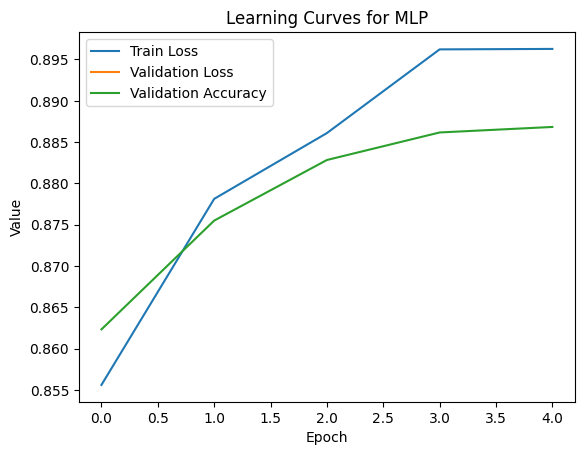

Training SimpleNN...
Epoch [1/5], Validation Accuracy: 0.8562
Epoch [2/5], Validation Accuracy: 0.8643
Epoch [3/5], Validation Accuracy: 0.8832
Epoch [4/5], Validation Accuracy: 0.8810
Epoch [5/5], Validation Accuracy: 0.8865
Test Accuracy for SimpleNN: 0.8772




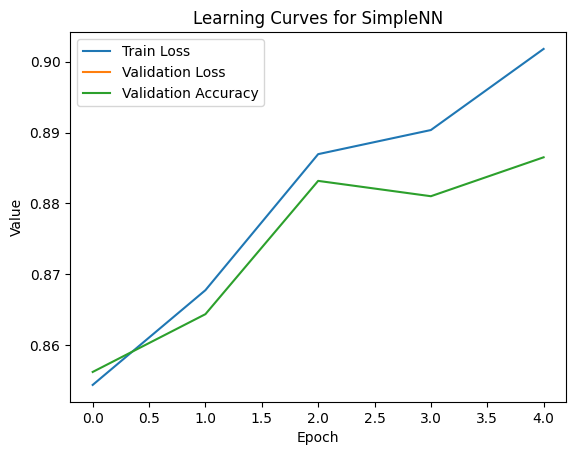

Training RNN...
Epoch [1/5], Validation Accuracy: 0.6673
Epoch [2/5], Validation Accuracy: 0.7747
Epoch [3/5], Validation Accuracy: 0.7408
Epoch [4/5], Validation Accuracy: 0.8045
Epoch [5/5], Validation Accuracy: 0.8073
Test Accuracy for RNN: 0.7918




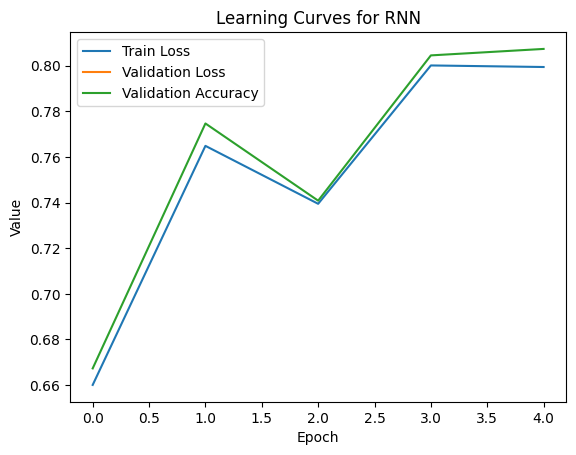

Training NeuralNetwork...
Epoch [1/5], Validation Accuracy: 0.8620
Epoch [2/5], Validation Accuracy: 0.8512
Epoch [3/5], Validation Accuracy: 0.8748
Epoch [4/5], Validation Accuracy: 0.8850
Epoch [5/5], Validation Accuracy: 0.8917
Test Accuracy for NeuralNetwork: 0.8759




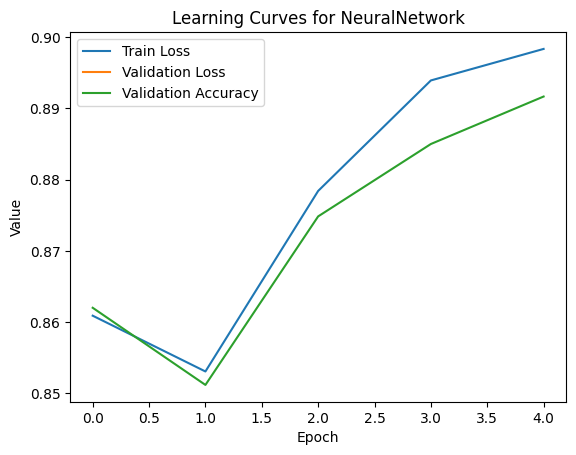

In [ ]:
# Создание экземпляров моделей
models = {
    "MLP": MLP(),
    "SimpleNN": SimpleNN(),
    "RNN": RNN(),
    "NeuralNetwork": NeuralNetwork(527, 673, 796)
}


def plot_learning_curves(history, title):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

# Обучение и оценка для каждой архитектуры
for model_name, model in models.items():
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    print(f"Training {model_name}...")
    for epoch in range(5):
        train_one_epoch(model, train_loader, criterion, optimizer)
        train_loss = evaluate_model(model, train_loader)
        val_accuracy = evaluate_model(model, val_loader)

        history['train_loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        print(f"Epoch [{epoch+1}/5], Validation Accuracy: {val_accuracy:.4f}")

    test_accuracy = evaluate_model(model, test_loader)
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")
    print("\n")

    plot_learning_curves(history, f"Learning Curves for {model_name}")
